# 차원축소 모듈
- input
    - input_df : pd.Dataframe
    - method : ['pca', 'tsne', 'tsvd', 'autoencoder'], default = pca
    - n_comp :int, default = 2
    - random_state : n ; int, default = 123
    - return_df : 1: result 를 pd.DataFrame으로 출력, 0: np.ndarray 로 출력 , default = 1
    - learning_rate : autoencoder learning rate, default = 0.001
    - n_epoch : autoencoder number of epoch, default = 30
    - cnt : autoencoder epoch 몇 번 마다 mse 출력할 것인지 ,int, default = 10
- output
    - result : np.ndarray(return_df = 0), pd.DataFrame(return_df = 1)

In [75]:

def dim_reduction(input_df, method = 'pca', n_comp =2 , random_state = 123, return_df = 1, learning_rate = 0.001,n_epoch = 30, cnt = 10):
    
    #import modules
    from sklearn.decomposition import PCA,TruncatedSVD
    from sklearn.manifold import TSNE
    import tensorflow as tf
    from tensorflow.contrib.layers import fully_connected
    
    if method == 'pca':
        result = PCA(n_components=n_comp, random_state=random_state).fit_transform(input_df.values)
    elif method == 'tsne':
        result  = TSNE(n_components=n_comp, random_state=random_state).fit_transform(input_df.values)
    elif method == 'tsvd':
        result = TruncatedSVD(n_components=n_comp, random_state=random_state).fit_transform(input_df.values)
    elif method == 'autoencoder':
        n_input = input_df.shape[1]
        n_hidden = n_comp
        n_output = n_input
        
        #set encoder
        x_ph = tf.placeholder(tf.float32,shape = [None,n_input])
        hidden_layer = fully_connected(x_ph,n_hidden,activation_fn=None)
        y_model = fully_connected(hidden_layer,n_output,activation_fn=None)
        
        #set loss function, optimizer
        loss = tf.reduce_mean(tf.square(x_ph-y_model)) # MSE
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) # Adam
        train = optimizer.minimize(loss)
        
        #Initiate variables
        init = tf.global_variables_initializer()
        
        #run session
        with tf.Session() as sess:
            sess.run(init)
            for i in range(n_epoch):
                my_feed = {x_ph:input_df.values}
                sess.run(train, feed_dict = my_feed)
                if i % 100 == 0: 
                    mse = sess.run(loss, feed_dict = my_feed)
                    print(i, "\tMSE loss:", mse)
            result = sess.run(hidden_layer, feed_dict = my_feed) 
        
    else :
        print('Value Error : Check reduction method [pca, tsne, tsvd, autoencoder]')
        return True
  
    print(f'{method} completed, {n_comp} components selected')
    
    if(return_df == 1):
        return pd.DataFrame(result)
    else : return result
        
    

# Test

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

In [67]:
# 시간이 오래걸려서 50:50 undersampling Data 로 test 했음

df = pd.read_csv(r'creditcard.csv')

# Scaling을 안했을 때 차원축소 효과가 좋지 않았음
df.Amount = RobustScaler().fit_transform(df.Amount.values.reshape(-1,1))
df.Time = RobustScaler().fit_transform(df.Time.values.reshape(-1,1))

fraud = df.loc[df.Class == 1]
df_suff = df.sample(frac = 1)
not_fraud = df_suff.loc[df.Class == 0][:492]

df_test = pd.concat([fraud,not_fraud])
x,y = df_test.drop(columns='Class'),df_test.Class

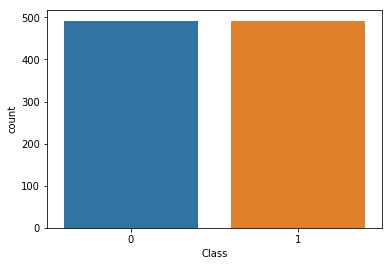

In [68]:
sb.countplot(y);

In [69]:
x_pca_df = dim_reduction(x,method = 'pca',return_df = 1,n_comp = 2)
x_pca_arr = dim_reduction(x,method = 'pca',return_df = 0,n_comp = 2)

pca completed, 2 components selected
pca completed, 2 components selected


In [70]:
x_tsne_df = dim_reduction(x,method = 'tsne',return_df = 1,n_comp = 2)
x_tsne_arr = dim_reduction(x,method = 'tsne',return_df = 0,n_comp = 2)

tsne completed, 2 components selected
tsne completed, 2 components selected


In [71]:
x_tsvd_df = dim_reduction(x,method = 'tsvd',return_df = 1,n_comp = 2)
x_tsvd_arr = dim_reduction(x,method = 'tsvd',return_df = 0,n_comp = 2)

tsvd completed, 2 components selected
tsvd completed, 2 components selected


In [72]:
x_auto_df = dim_reduction(x,method = 'autoencoder',return_df = 1,n_comp = 2)
x_auto_arr = dim_reduction(x,method = 'autoencoder',return_df = 0,n_comp = 2)

0 	MSE loss: 20.366783
autoencoder completed, 2 components selected
0 	MSE loss: 16.269629
autoencoder completed, 2 components selected


In [73]:
import seaborn as sb
import matplotlib.pyplot as plt

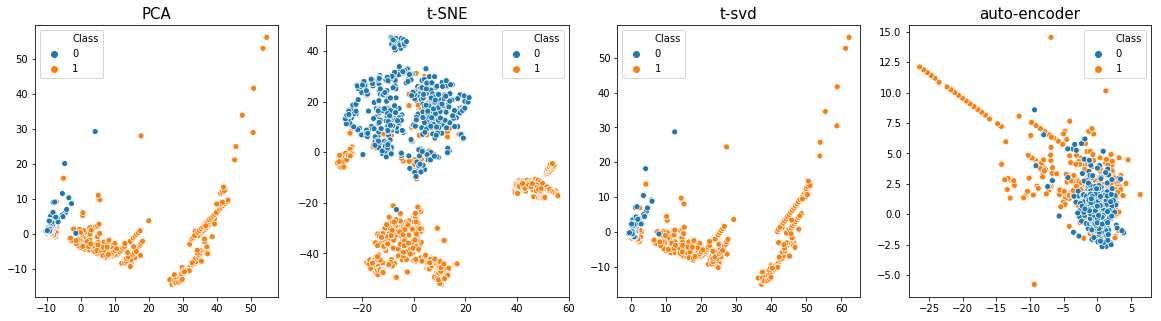

In [74]:
#시각화
fig,ax = plt.subplots(1,4,figsize = (20,5))
sb.scatterplot(x_pca_arr[:,0],x_pca_arr[:,1],hue = y, ax=ax[0])
ax[0].set_title('PCA',fontsize = 15)
sb.scatterplot(x_tsne_arr[:,0],x_tsne_arr[:,1],hue = y, ax=ax[1])
ax[1].set_title('t-SNE',fontsize = 15)
sb.scatterplot(x_tsvd_arr[:,0],x_tsvd_arr[:,1],hue = y, ax=ax[2])
ax[2].set_title('t-svd',fontsize = 15)
sb.scatterplot(x_auto_arr[:,0],x_auto_arr[:,1],hue = y, ax=ax[3])
ax[3].set_title('auto-encoder',fontsize = 15)
plt.show()